# Contents:
- perform EDA to understand the financial data to be analysed
- perform Feature Engeneering
- predict 5 day future percentage return using different models

# Tools:
- create moving averages and rsi
- dummy coding for day of the week
- LinearRegressor, RandomForestRegressor, GradientBoostingRegressor, KNN
- feature importance
- neural Networks with custom loss function, dropout and ensembling

# Import Package

In [1]:
import pandas as pd
import numpy as np
import talib

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import seaborn as sns

plt.style.use('seaborn')
plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import scale
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
import keras.losses

C:\Users\Thinkpad\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
Using TensorFlow backend.


In [2]:
lng_df = pd.read_csv('LNG.csv', parse_dates=['Date'])

In [3]:
spy_df = pd.read_csv('SPY.csv', parse_dates=['Date'])

# EDA

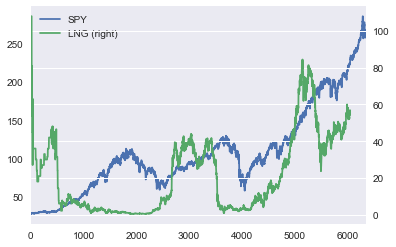

In [4]:
# Plot the Adj_Close columns for SPY and LNG
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)

Text(0.5, 0, 'adjusted close 1-day percent change')

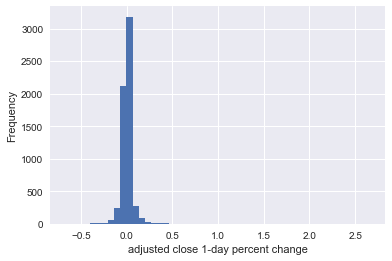

In [5]:
# Histogram of the daily price change percent of Adj_Close for LNG
lng_df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')

# Feature Engineering

## Create pct change features

In [6]:
# Create 5-day % changes of Adj_Close for the current day, and 5 days in the future
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

In [7]:
# Calculate the correlation matrix between the 5d close pecentage changes (current and future)
corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.034733
5d_close_future_pct     -0.034733             1.000000


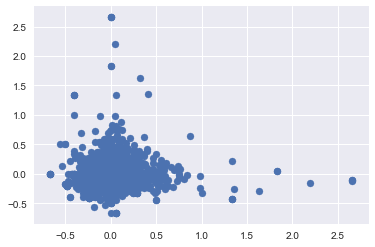

In [8]:
# Scatter the current 5-day percent change vs the future 5-day percent change
plt.scatter(lng_df['5d_close_pct'], lng_df['5d_close_future_pct'])
plt.show()

## Create moving average and RSI features
- Moving Average: values can be 14, 50, 200
- Relative Strength Index(RSI): 0: price is due to rebound from recent lows; 100: price is due to decline

In [9]:
# a list of the feature names for later
feature_names = ['5d_close_pct']  

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = talib.SMA(lng_df['Adj_Close'].values,
                              timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = talib.RSI(lng_df['Adj_Close'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


## Create volume features

In [10]:
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
#1-day % change
lng_df['Adj_Volume_1d_change'] = lng_df['Adj_Volume'].pct_change()
#moving averge
lng_df['Adj_Volume_1d_change_SMA'] = lng_df['Adj_Volume_1d_change'].rolling(window=5, center=False).mean().shift(0)

feature_names = new_features + feature_names

## Create day-of-week features

In [11]:
# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(lng_df['Date'].dt.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = lng_df.index

# Join the dataframe with the days of week dataframe
lng_df = pd.concat([lng_df, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 5)])
lng_df.dropna(inplace=True)  # drop missing values in-place

## Create features and targets

In [12]:
# Drop all na values
lng_df = lng_df.dropna()

# Create features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = lng_df[feature_names]
targets = lng_df['5d_close_future_pct']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['5d_close_future_pct'] + feature_names
feat_targ_df = lng_df[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()

## Check the correlations

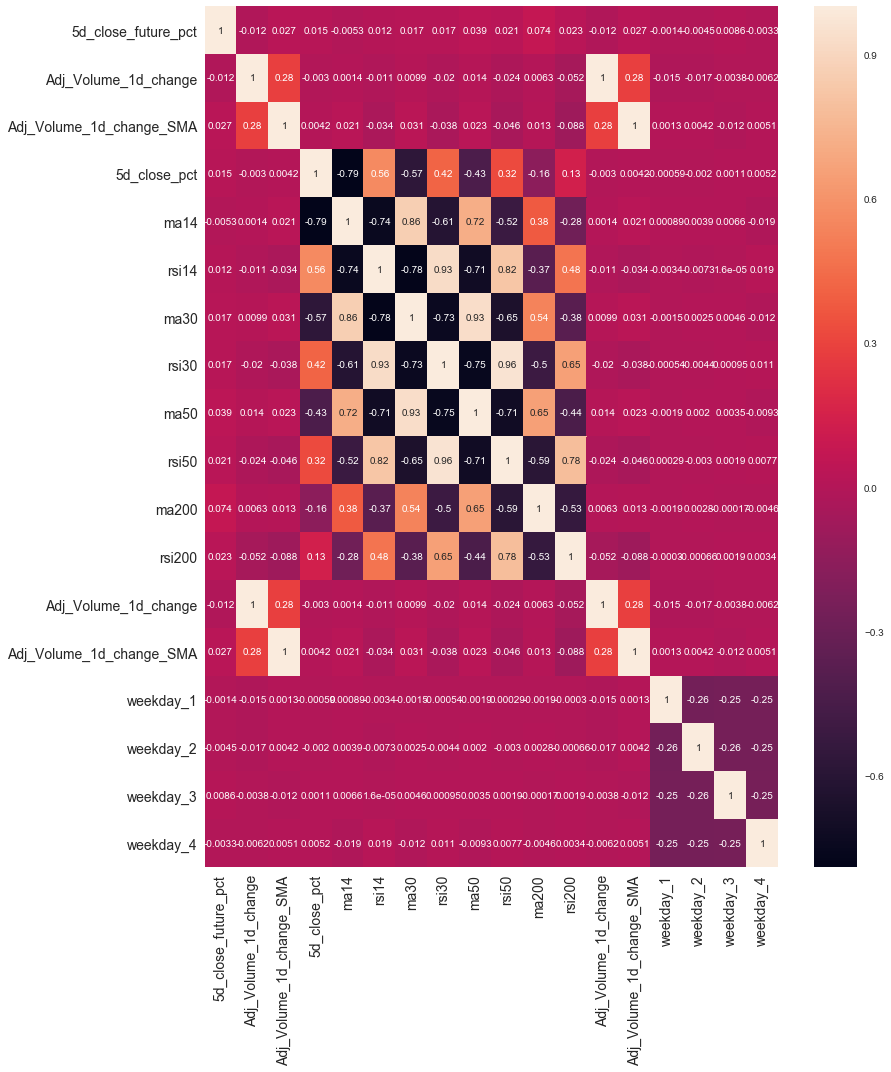

In [13]:
# Plot heatmap of correlation matrix
plt.figure(figsize=(13,15))
sns.heatmap(corr, annot= True,)
plt.yticks(rotation=0, size = 14); plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"

###  Create train and test features

In [14]:
# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * len(features))
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print(features.shape, train_features.shape, test_features.shape)

(5134, 17) (4363, 17) (771, 17)


# Model

## Linear Model

### Fit a linear model

In [15]:
# Add a constant to the features
linear_features = sm.add_constant(features)
linear_train_features = linear_features[:train_size]
linear_test_features = linear_features[train_size:]

C:\Users\Thinkpad\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [16]:
# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                                 OLS Regression Results                                 
Dep. Variable:     5d_close_future_pct   R-squared (uncentered):                   0.028
Model:                             OLS   Adj. R-squared (uncentered):              0.025
Method:                  Least Squares   F-statistic:                              8.323
Date:                 Fri, 10 Apr 2020   Prob (F-statistic):                    4.38e-19
Time:                         16:30:38   Log-Likelihood:                          2672.3
No. Observations:                 4363   AIC:                                     -5315.
Df Residuals:                     4348   BIC:                                     -5219.
Df Model:                           15                                                  
Covariance Type:             nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------

### Evaluate results

R^2 test: 0.0279


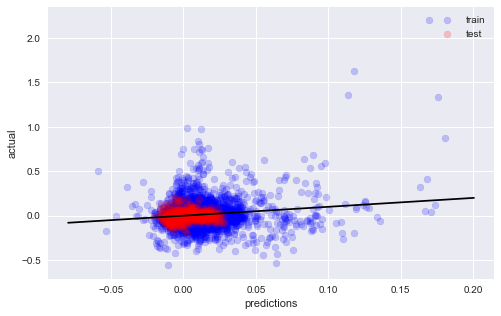

In [17]:
print(f"R^2 test: {(results.rsquared):0.4f}")

plt.figure(figsize=(8,5))
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

## Decision trees

### Fit a decision tree

In [18]:
# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features,train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.999999887981805
-4.061522248881728


### Try different max depths

In [19]:
# Loop through a few different max depths and check the performance
for d in [3, 5 ,10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.1350688400050467
-0.2929113717710705 

max_depth= 5
0.22171877006959384
-0.40186658944612375 

max_depth= 10
0.40308253915176684
-0.736581245728533 



### Evaluate results

R^2 train: 0.1351
R^2 test: -0.2929


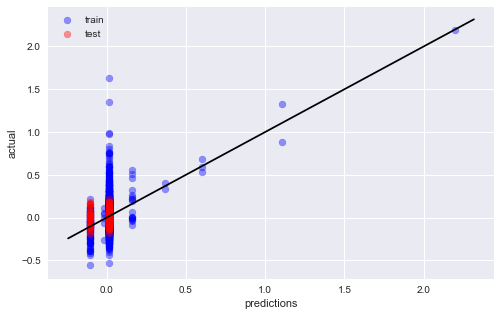

In [20]:
# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth = 3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

print(f"R^2 train: {decision_tree.score(train_features, train_targets):0.4f}") 
print(f"R^2 test: {decision_tree.score(test_features, test_targets):0.4f}")

plt.figure(figsize=(8,5))
# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

## Random forests

### Fit a random forest

In [21]:
# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.9109043945772375
-0.6523548898873894


### Tune random forest hyperparameters

In [22]:
#grid of hyperparameters
grid = {'n_estimators':[200], 'max_depth': [3, 5, 10], 'max_features': [4,8], 'random_state': [42]}
test_scores = []

rfr = RandomForestRegressor()
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    #default scoring is R^2
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.08204272564766035 {'random_state': 42, 'n_estimators': 200, 'max_features': 4, 'max_depth': 3}


### Evaluate results

R^2 train: 0.4328
R^2 test: -0.2307


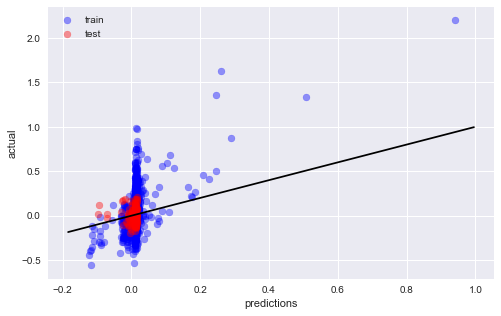

In [23]:
print(f"R^2 train: {rfr.score(train_features, train_targets):0.4f}") 
print(f"R^2 test: {rfr.score(test_features, test_targets):0.4f}")

# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

plt.figure(figsize=(8,5))
# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

### Random forest feature importances

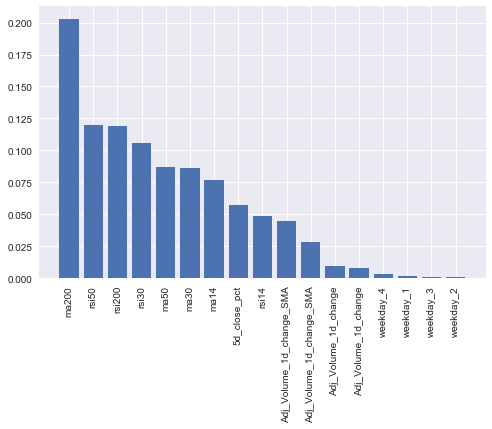

In [24]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

plt.figure(figsize=(8,5))
# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

## Gradient Boosting

### Fit a gradient boosting

In [25]:
# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.1706585043560367
-0.09562838496197323


### Evaluate results

R^2 train: 0.1707
R^2 test: -0.0956


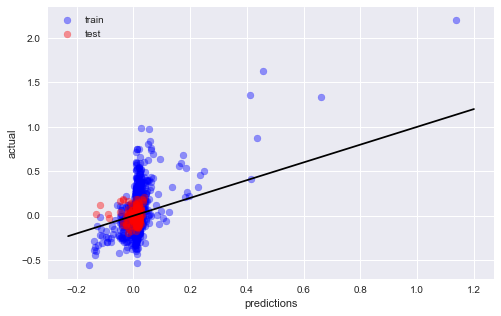

In [26]:
print(f"R^2 train: {gbr.score(train_features, train_targets):0.4f}") 
print(f"R^2 test: {gbr.score(test_features, test_targets):0.4f}")

# Make predictions with our model
train_predictions = gbr.predict(train_features)
test_predictions = gbr.predict(test_features)

plt.figure(figsize=(8,5))
# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

### Gradient boosting feature importances

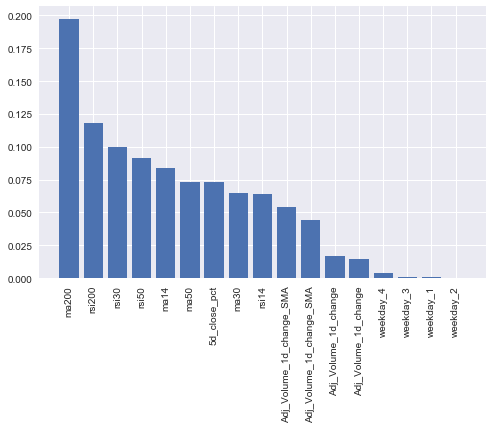

In [27]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(features.shape[1])

plt.figure(figsize=(8,5))
# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()

## KNN

### Scalling data

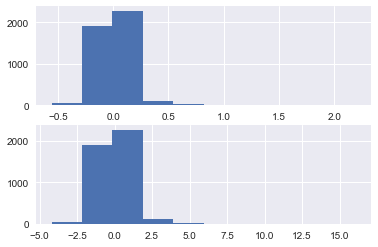

In [28]:
# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

### KNN regresssion

#### Fit a KNN model

In [29]:
for n in range(2,13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)    
    train_score = knn.score(scaled_train_features, train_targets)
    test_score = knn.score(scaled_test_features, test_targets)
    print(f'train / test scores: {train_score:0.4f} / {test_score:0.4f}')    
    print()  # prints a blank line

n_neighbors = 2
train / test scores: 0.7844 / -4.6936

n_neighbors = 3
train / test scores: 0.6558 / -3.6034

n_neighbors = 4
train / test scores: 0.5742 / -3.0032

n_neighbors = 5
train / test scores: 0.5010 / -2.3414

n_neighbors = 6
train / test scores: 0.4535 / -2.0012

n_neighbors = 7
train / test scores: 0.4093 / -1.8186

n_neighbors = 8
train / test scores: 0.3757 / -1.6161

n_neighbors = 9
train / test scores: 0.3433 / -1.4487

n_neighbors = 10
train / test scores: 0.3203 / -1.3773

n_neighbors = 11
train / test scores: 0.2968 / -1.2436

n_neighbors = 12
train / test scores: 0.2834 / -1.1501



#### Evaluate results

R^2 train: 0.5010
R^2 test: -2.3414


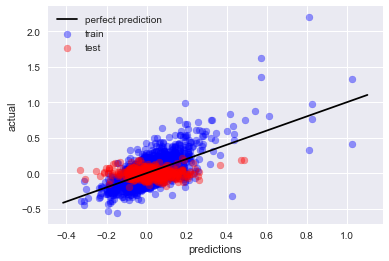

In [30]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(scaled_train_features, train_targets)

print(f"R^2 train: {knn.score(scaled_train_features, train_targets):0.4f}") 
print(f"R^2 test: {knn.score(scaled_test_features, test_targets):0.4f}")

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)


plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

## Nerual Networks

### A simple nerual net

#### Fit model

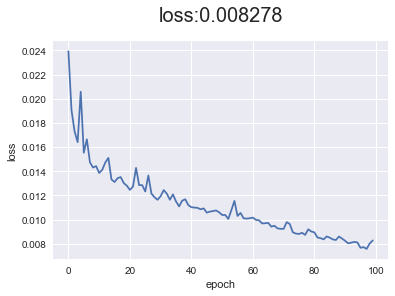

In [31]:
# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=100, verbose=0)

# Plot losses
loss = history.history['loss']
plt.plot(np.array(loss))
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### Evaluate results

R^2 train 0.5919
R^2 test -7.3002


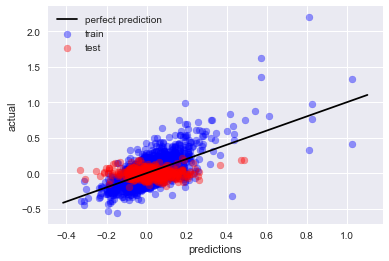

In [32]:
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(f"R^2 train {r2_score(train_targets, train_preds):0.4f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.4f}")

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

### A neural net with custom loss function

#### Create loss function
- tf.less: returns the truth value of (x < y) element-wise
- tf.where: return the elements
- tf.mean: computes the mean of elements across dimensions of a tensor.

In [33]:
# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x000001F08B9D7510>


##### Fit model

Epoch 1/25
4363/4363 [==============================] - 0s 72us/step - loss: 1.7467
Epoch 2/25
4363/4363 [==============================] - 0s 51us/step - loss: 1.1779
Epoch 3/25
4363/4363 [==============================] - 0s 47us/step - loss: 0.9547
Epoch 4/25
4363/4363 [==============================] - 0s 40us/step - loss: 1.7640
Epoch 5/25
4363/4363 [==============================] - 0s 37us/step - loss: 0.7045
Epoch 6/25
4363/4363 [==============================] - 0s 42us/step - loss: 0.5762
Epoch 7/25
4363/4363 [==============================] - 0s 55us/step - loss: 0.6585
Epoch 8/25
4363/4363 [==============================] - 0s 53us/step - loss: 0.6961
Epoch 9/25
4363/4363 [==============================] - 0s 55us/step - loss: 0.7166
Epoch 10/25
4363/4363 [==============================] - 0s 64us/step - loss: 0.6300
Epoch 11/25
4363/4363 [==============================] - 0s 62us/step - loss: 0.7483
Epoch 12/25
4363/4363 [==============================] - 0s 58us/step - lo

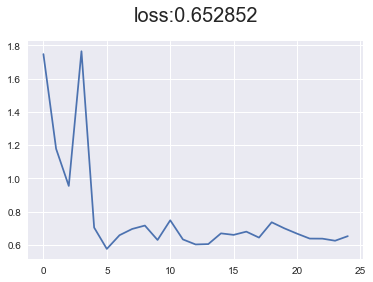

In [34]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

#### Evaluate results

R^2 train 0.035
R^2 test -0.167


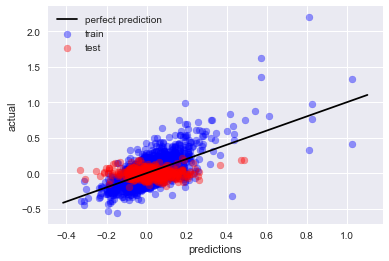

In [35]:
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(f"R^2 train {r2_score(train_targets, train_preds):0.3f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.3f}")

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

### A neural net with dropout

#### Fit model

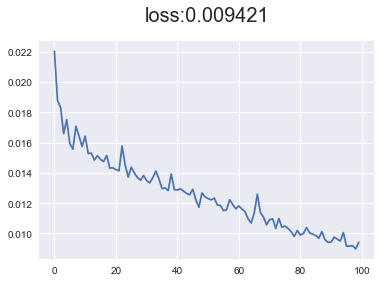

In [36]:
# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(500, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(100, activation='relu'))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=100, verbose=0)

#plot loss
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

#### Evaluate results

R^2 train 0.035
R^2 test -7.101


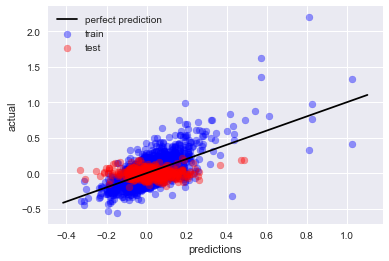

In [37]:
test_preds = model_3.predict(scaled_test_features)
print(f"R^2 train {r2_score(train_targets, train_preds):0.3f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.3f}")

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

### Ensembling models

#### Fit model

In [38]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[ 0.03734895  0.03221467  0.05847316  0.00483941 -0.0443697 ]


#### Evaluate results

R^2 train 0.525
R^2 test -1.975


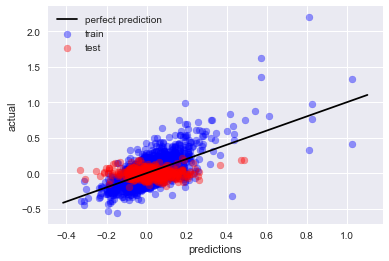

In [39]:
print(f"R^2 train {r2_score(train_targets, train_preds):0.3f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.3f}")

plt.scatter(train_predictions, train_targets, alpha=0.4, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()